#                                       Big Data Infrastructure Projekt

## Zusammenhang zwischen positiven Covid19-Testungen und Impfungen

In diesem Big Data Infrastructure Projekt geht es darum  die Anzahl der positiven Testungen sowie die Impfungen in Österreich bzw. in den jeweiligen Bundesländern/Gemeinden zu analysieren, zu visualisieren und miteinander in Zusammenhang zu setzen. 

In diesem Jupiter-Notebook werden alle relevanten Schritte (sowie Erklärungen dazu) dokumentiert.

Zuerst wird ein Docker Container erstellt. Dieser enthällt einen Container, ein neo4j Image, auf welches durch die Ports 7474 und 7687 zugegriffen wird, sowie auch ein Volume und die Verbindung mit neo4j mit Username und Passwort.

In [1]:
!docker-compose -p completx_sql up -d

 Container neo4j-container  Created
 Container neo4j-container  Starting
 Container neo4j-container  Started


Um Neo4j zu verwenden, müssen Sie es und seinen Python-Treiber installieren. Darüber hinaus erleichtert die Installation der Bibliothek py2neo die Verbindungen und Interaktionen mit der Neo4j-Datenbank.

In [2]:
pip install neo4j

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\A8779\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
pip install py2neo

     ------------------------------------ 177.2/177.2 KB 222.6 kB/s eta 0:00:00
     -------------------------------------- 121.1/121.1 KB 1.2 MB/s eta 0:00:00
     -------------------------------------- 163.8/163.8 KB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\A8779\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [29]:
pip install requests

     ---------------------------------------- 62.6/62.6 KB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 66.8/66.8 KB 1.2 MB/s eta 0:00:00
     -------------------------------------- 100.4/100.4 KB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\A8779\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [37]:
pip install matplotlib

     ---------------------------------------- 7.7/7.7 MB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 1.5 MB/s eta 0:00:00
     -------------------------------------- 182.8/182.8 KB 3.8 MB/s eta 0:00:00
     -------------------------------------- 56.2/56.2 KB 977.9 kB/s eta 0:00:00
     -------------------------------------- 103.2/103.2 KB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\A8779\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Des weiteren werden Pandas, CSV, Requests und verschiedene Modules von Py2Neo importiert.

In [30]:
from py2neo import Graph, Node, Relationship
import csv
import pandas as pd
import requests

Die benötigten CSV-Dateien werden mithilfe von pdf.read_csv eingelesen.
Ingesamt gibt es vier CSV-Dateien. Drei davon enthalten Informationen über die Impfungen für die Jahre 2021, 2022 und 2023. Die vierte Datei gibt Information über die positiven Testungen pro Bundesland in den Jahren 2021 bis Ende 2022.  

In [5]:
faelle = pd.read_csv('timeline-faelle-bundeslaender.csv',delimiter=';')
vaccines_2021_cumulated = pd.read_csv('impfungen_2021.csv',delimiter=';')
vaccines_2022_cumulated = pd.read_csv('impfungen_2022.csv',delimiter=';')
vaccines_2023_cumulated = pd.read_csv('impfungen_2023.csv',delimiter=';')

Im folgenden ein paar allgemeine Informationen über Struktur und Inhalt der CSV-Dateien.

In [6]:
faelle.head()

,Datum,BundeslandID,Name,Testungen,TestungenPCR,TestungenAntigen
0,2021-03-01T09:30:00+01:00,1,Burgenland,638575,155435,483140
1,2021-03-01T09:30:00+01:00,2,Kärnten,675557,217933,457624
2,2021-03-01T09:30:00+01:00,3,Niederösterreich,3400756,1141984,2258772
3,2021-03-01T09:30:00+01:00,4,Oberösterreich,2162517,546777,1615740
4,2021-03-01T09:30:00+01:00,5,Salzburg,823353,274598,548755


In [7]:
faelle.tail()

,Datum,BundeslandID,Name,Testungen,TestungenPCR,TestungenAntigen
6595,2022-12-20T09:30:00+02:00,6,Steiermark,22515339,6653515,15861824
6596,2022-12-20T09:30:00+02:00,7,Tirol,10201158,4456324,5744834
6597,2022-12-20T09:30:00+02:00,8,Vorarlberg,7295131,1652804,5642327
6598,2022-12-20T09:30:00+02:00,9,Wien,73308019,65638829,7669190
6599,2022-12-20T09:30:00+02:00,10,Österreich,204039989,107516250,96523739


In [8]:
vaccines_2021_cumulated.head()

,Datum,Gemeindecode,Einwohner,Teilgeimpfte,TeilgeimpftePro100,Vollimmunisierte,VollimmunisiertePro100
0,2021-12-14T23:59:59+01:00,10101,14895,11666,78.321584,10961,73.588453
1,2021-12-14T23:59:59+01:00,10201,2000,1592,79.600000,1512,75.600000
2,2021-12-14T23:59:59+01:00,10301,1883,1506,79.978757,1444,76.686139
3,2021-12-14T23:59:59+01:00,10302,1841,1505,81.749049,1424,77.349267
4,2021-12-14T23:59:59+01:00,10303,2122,1672,78.793591,1591,74.976437


In [9]:
vaccines_2022_cumulated.head()

,date,municipality_id,municipality_name,municipality_population,dose_1,dose_2,dose_3,dose_4,dose_5+,vaccinated_according_to_recommendation,vaccinated_according_to_recommendation_percent
0,2022-10-12T23:59:59+02:00,10101,Eisenstadt,15485,12284,12037,9752,2169,18,9889,63.861802
1,2022-10-12T23:59:59+02:00,10201,Rust,2008,1644,1622,1356,261,4,1323,65.886454
2,2022-10-12T23:59:59+02:00,10301,Breitenbrunn am Neusiedler See,1922,1570,1552,1321,347,2,1340,69.719043
3,2022-10-12T23:59:59+02:00,10302,Donnerskirchen,1854,1552,1533,1298,281,0,1303,70.280475
4,2022-10-12T23:59:59+02:00,10303,Großhöflein,2099,1793,1759,1441,209,2,1465,69.795141


In [10]:
vaccines_2023_cumulated.head()

,date,municipality_id,municipality_name,municipality_population,vaccination_1,vaccination_2,vaccination_3,vaccination_4+
0,2024-01-01T23:59:59+01:00,10101,Eisenstadt,15924,12095,11851,9740,3639
1,2024-01-01T23:59:59+01:00,10201,Rust,1978,1595,1572,1329,500
2,2024-01-01T23:59:59+01:00,10301,Breitenbrunn am Neusiedler See,1921,1517,1493,1285,569
3,2024-01-01T23:59:59+01:00,10302,Donnerskirchen,1857,1525,1505,1295,489
4,2024-01-01T23:59:59+01:00,10303,Großhöflein,2085,1739,1711,1411,433


In [11]:
vaccines_2021_cumulated.tail()

,Datum,Gemeindecode,Einwohner,Teilgeimpfte,TeilgeimpftePro100,Vollimmunisierte,VollimmunisiertePro100
2112,2021-12-14T23:59:59+01:00,91901,73861,55925,75.716549,52359,70.888561
2113,2021-12-14T23:59:59+01:00,92001,85264,57768,67.751923,53092,62.267780
2114,2021-12-14T23:59:59+01:00,92101,173916,126752,72.881161,116970,67.256607
2115,2021-12-14T23:59:59+01:00,92201,198806,149592,75.245214,138751,69.792159
2116,2021-12-14T23:59:59+01:00,92301,111812,84124,75.237005,78109,69.857439


In [12]:
vaccines_2022_cumulated.tail()

,date,municipality_id,municipality_name,municipality_population,dose_1,dose_2,dose_3,dose_4,dose_5+,vaccinated_according_to_recommendation,vaccinated_according_to_recommendation_percent
2110,2022-10-12T23:59:59+02:00,91901,Wien,75311,59229,57479,45842,11104,182,46412,61.627120
2111,2022-10-12T23:59:59+02:00,92001,Wien,84965,62179,59181,41511,7448,73,43494,51.190490
2112,2022-10-12T23:59:59+02:00,92101,Wien,181859,134331,129263,96569,18888,138,99984,54.978857
2113,2022-10-12T23:59:59+02:00,92201,Wien,208487,158431,153540,118550,21673,158,122136,58.582070
2114,2022-10-12T23:59:59+02:00,92301,Wien,116979,88831,85885,66592,14702,118,68510,58.566067


In [13]:
vaccines_2023_cumulated.tail()

,date,municipality_id,municipality_name,municipality_population,vaccination_1,vaccination_2,vaccination_3,vaccination_4+
2110,2024-01-01T23:59:59+01:00,91901,Wien 19. Döbling,75538,56636,54886,44430,17876
2111,2024-01-01T23:59:59+01:00,92001,Wien 20. Brigittenau,86663,59122,56133,39894,12837
2112,2024-01-01T23:59:59+01:00,92101,Wien 21. Floridsdorf,185847,133412,128129,96106,32764
2113,2024-01-01T23:59:59+01:00,92201,Wien 22. Donaustadt,219026,161785,156582,121503,40595
2114,2024-01-01T23:59:59+01:00,92301,Wien 23. Liesing,120393,88895,85791,66808,25195


In [14]:
faelle.shape

(6600, 6)

In [15]:
vaccines_2021_cumulated.shape

(2117, 7)

In [16]:
vaccines_2022_cumulated.shape

(2115, 11)

In [17]:
vaccines_2023_cumulated.shape

(2115, 8)

Wie unten ersichtlich, besteht der Datensatz aus einem Datum, welches mit Uhrzeit angegeben ist, der BundeslandID, dem Namen des jeweiligen Bundesland sowie der Anzahl der durchgeführten Coronatests. Diese werden dann wieder aufgeteilt in PCR- und Antigentests.

In [18]:
faelle.columns.tolist()

['Datum',
 'BundeslandID',
 'Name',
 'Testungen',
 'TestungenPCR',
 'TestungenAntigen']

Der Impfungsdatensatz besteht, wie durch die Form ersichtlich ist, aus 8 Spalten. Diese beinhalten, wie oben erwähnt, das Datum mit Uhrzeit, die ID des Bezirks (diese sind nach der ersten Zahl auch dem jeweiligen Bundesland zuordenbar), den Namen des Bezirks, die Bevölkerung und dann die Anzahl der Personen, die die jeweilige Impfungsanzahl erhalten haben.

In [20]:
vaccines_2022_cumulated.columns.tolist()

['date',
 'municipality_id',
 'municipality_name',
 'municipality_population',
 'dose_1',
 'dose_2',
 'dose_3',
 'dose_4',
 'dose_5+',
 'vaccinated_according_to_recommendation',
 'vaccinated_according_to_recommendation_percent']

Es wird noch überprüft, ob einige Datensätze unvollständig sind oder fehlende Werte aufweisen.

In [21]:
faelle.isnull().sum()

Datum               0
BundeslandID        0
Name                0
Testungen           0
TestungenPCR        0
TestungenAntigen    0
dtype: int64

In [22]:
vaccines_2021_cumulated.isnull().sum()

Datum                     0
Gemeindecode              0
Einwohner                 0
Teilgeimpfte              0
TeilgeimpftePro100        0
Vollimmunisierte          0
VollimmunisiertePro100    0
dtype: int64

In [23]:
vaccines_2022_cumulated.isnull().sum()

date                                              0
municipality_id                                   0
municipality_name                                 0
municipality_population                           0
dose_1                                            0
dose_2                                            0
dose_3                                            0
dose_4                                            0
dose_5+                                           0
vaccinated_according_to_recommendation            0
vaccinated_according_to_recommendation_percent    0
dtype: int64

In [24]:
vaccines_2023_cumulated.isnull().sum()

date                       0
municipality_id            0
municipality_name          0
municipality_population    0
vaccination_1              0
vaccination_2              0
vaccination_3              0
vaccination_4+             0
dtype: int64

In diesem Fall sind alle Datensätze vollständig. Abschließend werden noch die allgemeinen Eigenschaften des Datensatzes angezeigt:

In [25]:
faelle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Datum             6600 non-null   object
 1   BundeslandID      6600 non-null   int64 
 2   Name              6600 non-null   object
 3   Testungen         6600 non-null   int64 
 4   TestungenPCR      6600 non-null   int64 
 5   TestungenAntigen  6600 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 309.5+ KB


In [26]:
vaccines_2023_cumulated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   date                     2115 non-null   object
 1   municipality_id          2115 non-null   int64 
 2   municipality_name        2115 non-null   object
 3   municipality_population  2115 non-null   int64 
 4   vaccination_1            2115 non-null   int64 
 5   vaccination_2            2115 non-null   int64 
 6   vaccination_3            2115 non-null   int64 
 7   vaccination_4+           2115 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 132.3+ KB


* Es ist ein DataFrame.
* Es gibt 6600 Einträge, d.h. 6600 Zeilen.
* Jede Zeile hat eine Zeilenbeschriftung (auch bekannt als index) mit Werten von 0 bis 6599.
* Die Tabelle hat 6 Spalten. Alle Spalten haben einen Wert für jede der Zeilen (alle 6600 Werte sind non-null).
* Die Spalten Datum und Name bestehen aus Textdaten (Strings, auch bekannt als object). Die anderen Spalten sind numerische Daten, von denen alle ganze Zahlen (aka integer) sind.
* Die Art der Daten (Zeichen, Ganzzahlen,…) in den verschiedenen Spalten werden durch Auflisten der dtypes dargestellt.
* Die ungefähre Menge an RAM, die zum Halten des DataFrame verwendet wird, wird ebenfalls angegeben. Das ist in dem Fall ~310 kb

In [ ]:
# vaccines.info()

* Es ist ein DataFrame.
* Es gibt 2115 Einträge, d.h. 2115 Zeilen.
* Jede Zeile hat eine Zeilenbeschriftung (auch bekannt als index) mit Werten von 0 bis 2114.
* Die Tabelle hat 8 Spalten. Alle Spalten haben einen Wert für jede der Zeilen (alle 6600 Werte sind non-null).
* Die Spalten Date und Bezirks-name bestehen aus Textdaten (Strings, auch bekannt als object). Die anderen Spalten sind numerische Daten, von denen alle ganze Zahlen (aka integer) sind.
* Die Art der Daten (Zeichen, Ganzzahlen,…) in den verschiedenen Spalten werden durch Auflisten der dtypes dargestellt.
* Die ungefähre Menge an RAM, die zum Halten des DataFrame verwendet wird, wird ebenfalls angegeben. Das ist in dem Fall ~133 kb

In [27]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"
password = "aveQho9yf6tx29vgW3kv"

graph = Graph(uri, auth=(username, password))
driver=GraphDatabase.driver(uri, auth=(username, password))


In [111]:
url = "http://localhost:7474/browser/"
response = requests.get(url)

if response.status_code == 200:
    print("Website is accessible.")
else:
    print("Failed to access website.")



Website is accessible.


Im Folgenden werden die vier CSV-Dateien in die Datenbank eingespeichert.

In [32]:
with open('impfungen_2023.csv', 'r') as csvfile:
    csvreader = csv.DictReader(csvfile, delimiter=';')
    
    for row in csvreader:
            stripped_row = {key.replace('ï»¿', ''): value for key, value in row.items()}
            # Create a Node for each row in the CSV file
            impfPatient_node = Node("Impf_Patient",
                                    datum=row['date'],
                                    bezirkId=row['municipality_id'],
                                    bezirksName=row['municipality_name'],
                                    ersteImpfung=row['vaccination_1'],
                                    zweiteImpfung=row['vaccination_2'],
                                    dritteImpfung=row['vaccination_3'],
                                    mehrAls3=row['vaccination_4+'])
            
            # Add the Node to the graph
            graph.create(impfPatient_node)

In [33]:
with open('impfungen_2021.csv', 'r') as csvfile:
    csvreader = csv.DictReader(csvfile, delimiter=';')
    
    for row in csvreader:
            stripped_row = {key.replace('ï»¿', ''): value for key, value in row.items()}
            # Create a Node for each row in the CSV file
            impfPatient_node = Node("Impf_Patient",
                                    datum=stripped_row['Datum'],
                                    bezirkId=row['Gemeindecode'],
                                    population=row['Einwohner'],
                                    ersteImpfung=row['Teilgeimpfte'],
                                    zweiteImpfung=row['Vollimmunisierte'])
            
            # Add the Node to the graph
            graph.create(impfPatient_node)

In [34]:
with open('impfungen_2022.csv', 'r') as csvfile:
    csvreader = csv.DictReader(csvfile, delimiter=';')
    
    for row in csvreader:
            stripped_row = {key.replace('ï»¿', ''): value for key, value in row.items()}
            # Create a Node for each row in the CSV file
            impfPatient_node = Node("Impf_Patient",
                                    datum=stripped_row['date'],
                                    bezirkId=row['municipality_id'],
                                    bezirksName=row['municipality_name'],
                                    ersteImpfung=row['dose_1'],
                                    zweiteImpfung=row['dose_2'],
                                    dritteImpfung=row['dose_3'],
                                    vierteImpfung=row['dose_4'],
                                    mehrAlsVier=row['dose_5+'])
            
            # Add the Node to the graph
            graph.create(impfPatient_node)

In [35]:
with open('timeline-faelle-bundeslaender.csv', 'r') as csvfile:
    csvreader = csv.DictReader(csvfile, delimiter=';')
    
    for row in csvreader:
            stripped_row = {key.replace('ï»¿', ''): value for key, value in row.items()}
            tests_value = stripped_row['Testungen']
            tests_value = int(tests_value) if tests_value.isdigit() else None
            # Create a Node for each row in the CSV file
            impfPatient_node = Node("Tests",
                                datum=stripped_row['Datum'],
                                BundeslandID=row['BundeslandID'],
                                BundeslandName=row['Name'],
                                Tests=int(tests_value),
                                PCR=row['TestungenPCR'],
                                Antigen=row['TestungenAntigen'],
                               )
            
            # Add the Node to the graph
            graph.create(impfPatient_node)

Um eine Verbindung zur Datenbank herzustellen, muss eine URL eingeben, über die die Verbindung hergestellt wird, sowie Authentifizierungsdaten, bestehend aus Benutzername und Passwort. Mit py2neo kann dann die Verbindung mithilfe von Graph hergestellt werden. Dies ist auch mit GraphDatabase von noe4j möglich.

Um zu überprüfen, ob die Seite aktiv ist, kann diese Funktion verwendet werden:

C:\Users\A8779\AppData\Local\Temp\ipykernel_11080\644276352.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['t.BundeslandName'].replace({None: 'Unknown'}, inplace=True)
C:\Users\A8779\AppData\Local\Temp\ipykernel_11080\644276352.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

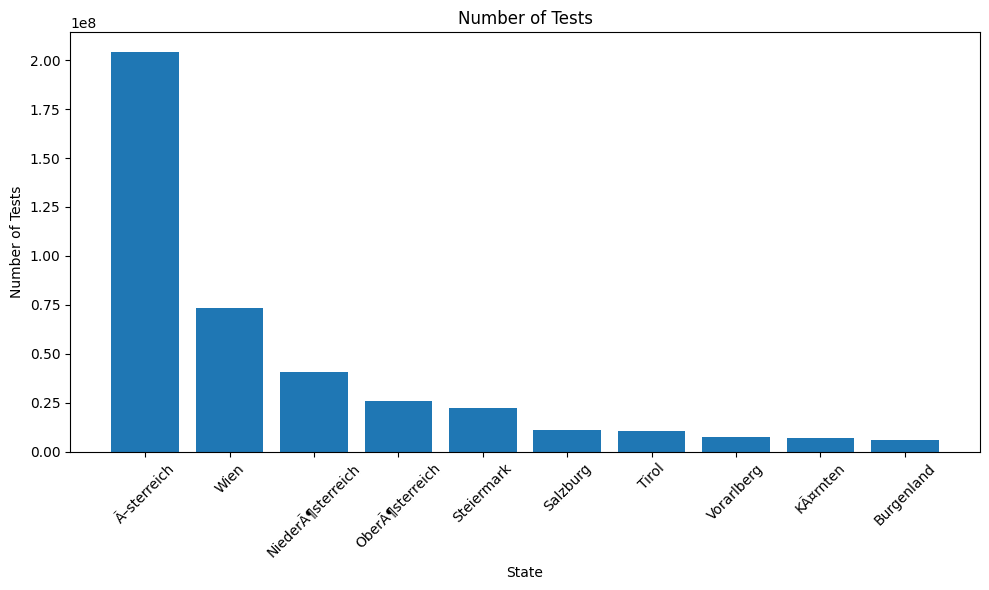

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
from neo4j import GraphDatabase
import numpy as np  # Import numpy for array operations

# Run Cypher query
result = graph.run("""
MATCH (t:Tests) where t.BundeslandName <> 'Österreich'AND t.BundeslandName <> 'Ã–sterreich'
RETURN t.BundeslandName, t.Tests
ORDER BY t.Tests DESC
""")

# Convert result to DataFrame
df = pd.DataFrame([r.values() for r in result], columns=result.keys())

# Replace None values with np.nan (NaN) or a default value
df['t.BundeslandName'].replace({None: 'Unknown'}, inplace=True)
df['t.Tests'].replace({None: 0}, inplace=True)  # Replace with 0 or np.nan based on your preference

# Convert 't.Tests' column to numeric (in case it's not already)
df['t.Tests'] = pd.to_numeric(df['t.Tests'])

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(df['t.BundeslandName'], df['t.Tests'])
plt.xlabel('State')
plt.ylabel('Number of Tests')
plt.title('Number of Tests')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


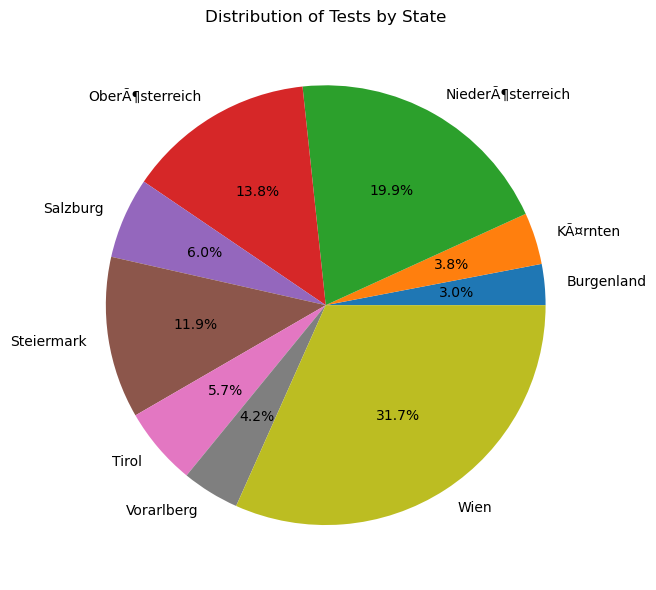

In [108]:
cypher_query = """
MATCH (t:Tests)
WHERE t.BundeslandName <> 'Österreich' AND t.BundeslandName <> 'Ã–sterreich'
RETURN t.BundeslandName, sum(t.Tests) as Tests
"""

result = graph.run(cypher_query)

# Convert result to DataFrame
df = pd.DataFrame([dict(r) for r in result], columns=['t.BundeslandName', 'Tests'])

# Replace None values with 'Unknown' for BundeslandName and 0 for Tests
df['t.BundeslandName'].replace({None: 'Unknown'}, inplace=True)
df['Tests'].replace({None: 0}, inplace=True)

# Convert 'Tests' column to numeric (in case it's not already)
df['Tests'] = pd.to_numeric(df['Tests'], errors='coerce')

# Remove rows with non-finite 'Tests' values
df = df[np.isfinite(df['Tests'])]

# Create pie chart
plt.figure(figsize=(10, 6))
plt.pie(df['Tests'], labels=df['t.BundeslandName'], autopct='%1.1f%%')
plt.title('Distribution of Tests by State')
plt.tight_layout()
plt.show()



C:\Users\hicke\AppData\Local\Temp\ipykernel_10132\1812702006.py:8: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


<Figure size 1200x600 with 0 Axes>

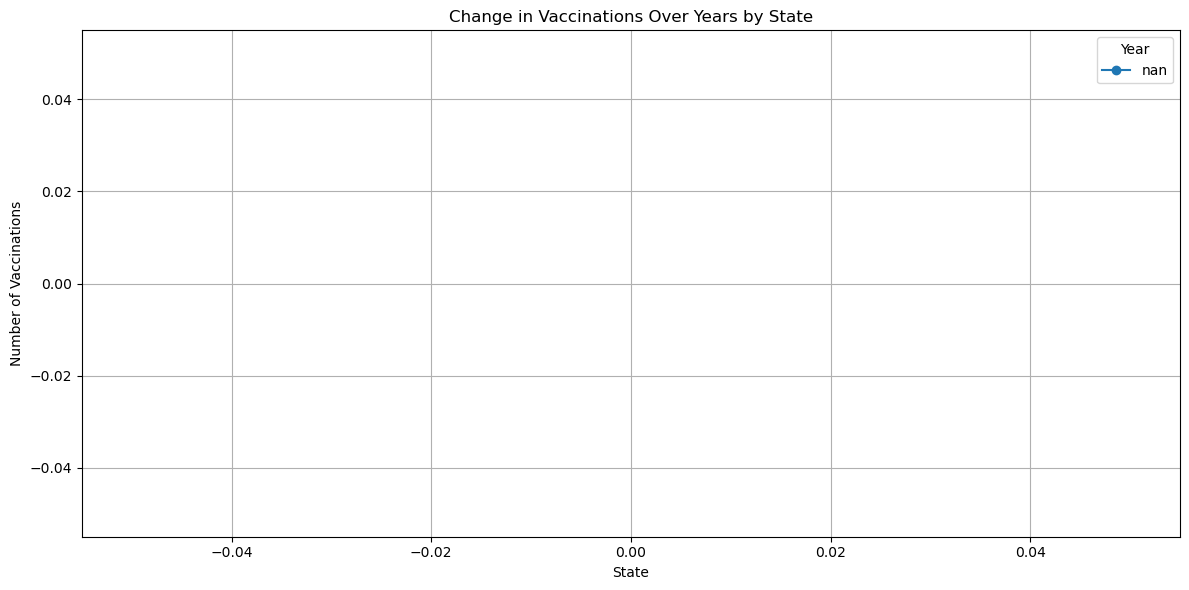

In [110]:
# Cypher query to retrieve vaccination data
cypher_query = """
MATCH (i:Impf_Patient)
RETURN i.BundeslandName AS BundeslandName, i.Year AS Year, sum(i.Vaccinations) AS Vaccinations
ORDER BY BundeslandName, Year
"""

with driver.session() as session:
    result = session.run(cypher_query)
    df = pd.DataFrame([dict(record) for record in result])

# Pivot the DataFrame to have Years as columns
df_pivot = df.pivot(index='BundeslandName', columns='Year', values='Vaccinations')

# Plotting
plt.figure(figsize=(12, 6))
df_pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Change in Vaccinations Over Years by State')
plt.xlabel('State')
plt.ylabel('Number of Vaccinations')
plt.grid(True)
plt.tight_layout()
plt.show()



In [291]:
cypher_query = """
MATCH (i:Impf_Patient)
RETURN i.bezirkId AS bezirk, i.datum AS Year, sum(i.ersteImpfung) AS Vaccinations
ORDER BY bezirk, Year
"""

with driver.session() as session:
    result = session.run(cypher_query)
    df = pd.DataFrame([dict(record) for record in result])

# Print DataFrame columns to verify
print(df.columns)

# Pivot the DataFrame to have Years as columns
df_pivot = df.pivot(index='bezirk', columns='Year', values='Vaccinations')

# Plotting
plt.figure(figsize=(12, 6))
df_pivot.plot(kind='bar', figsize=(12, 6), stacked=True)
plt.title('Total Vaccinations Over Years by District')
plt.xlabel('District (bezirk)')
plt.ylabel('Number of Vaccinations')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

Index(['bezirk', 'Year', 'Vaccinations'], dtype='object')


KeyError: 'datum'

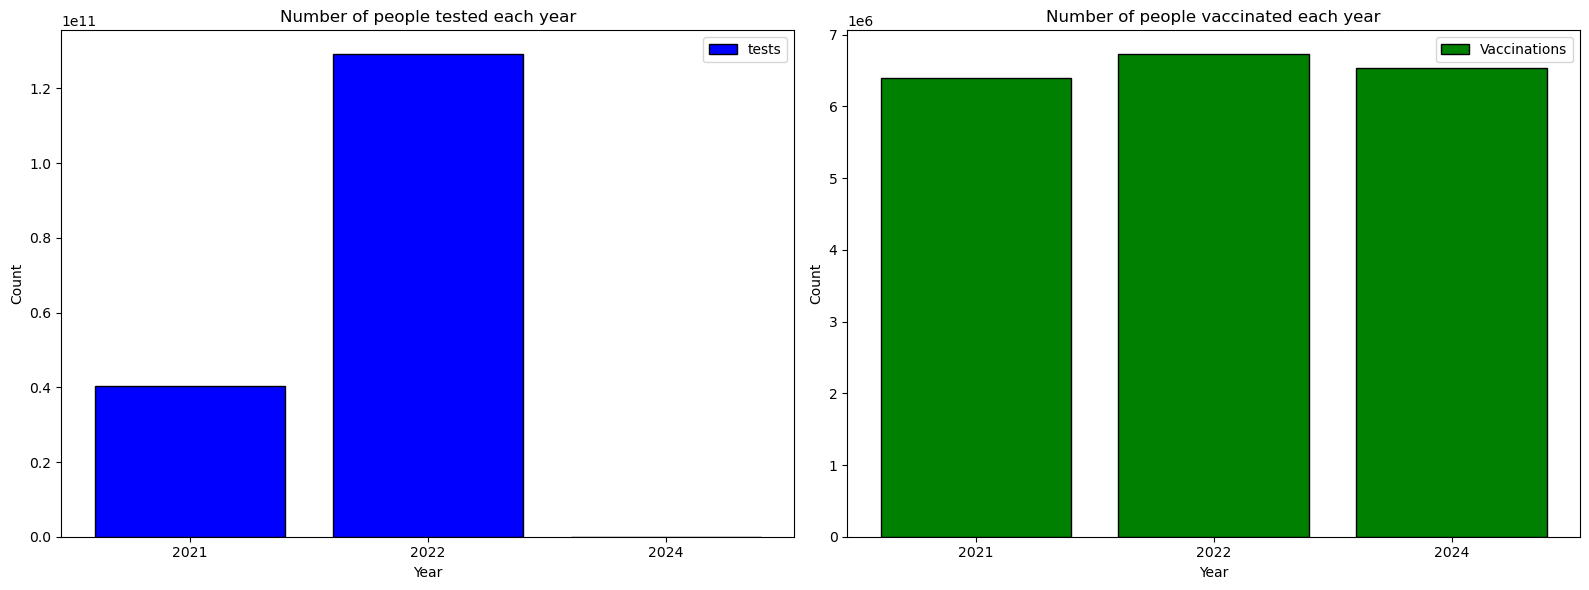

In [289]:
cypher_query = """
MATCH (n)
RETURN n.datum AS Year, sum(n.Tests) AS tests, sum(n.ersteImpfung) AS Vaccinations
ORDER BY Year
"""

with driver.session() as session:
    result = session.run(cypher_query)
    df = pd.DataFrame([dict(record) for record in result])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Diagram for Tests
ax1.bar(df['Year'], df['tests'], color='b', edgecolor='black', label='tests')
ax1.set_xlabel("Year")
ax1.set_ylabel("Count")
ax1.set_title("Number of people tested each year")
ax1.set_xticks(df['Year'])
ax1.legend()

# Diagram for Vaccinations
ax2.bar(df['Year'], df['Vaccinations'], color='g', edgecolor='black', label='Vaccinations')
ax2.set_xlabel("Year")
ax2.set_ylabel("Count")
ax2.set_title("Number of people vaccinated each year")
ax2.set_xticks(df['Year'])
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


Oder mit localhost:7687 kann man neo4j im Browser starten und sich dann mit den Daten anmelden und schauen ob die Verbindung möglich ist.

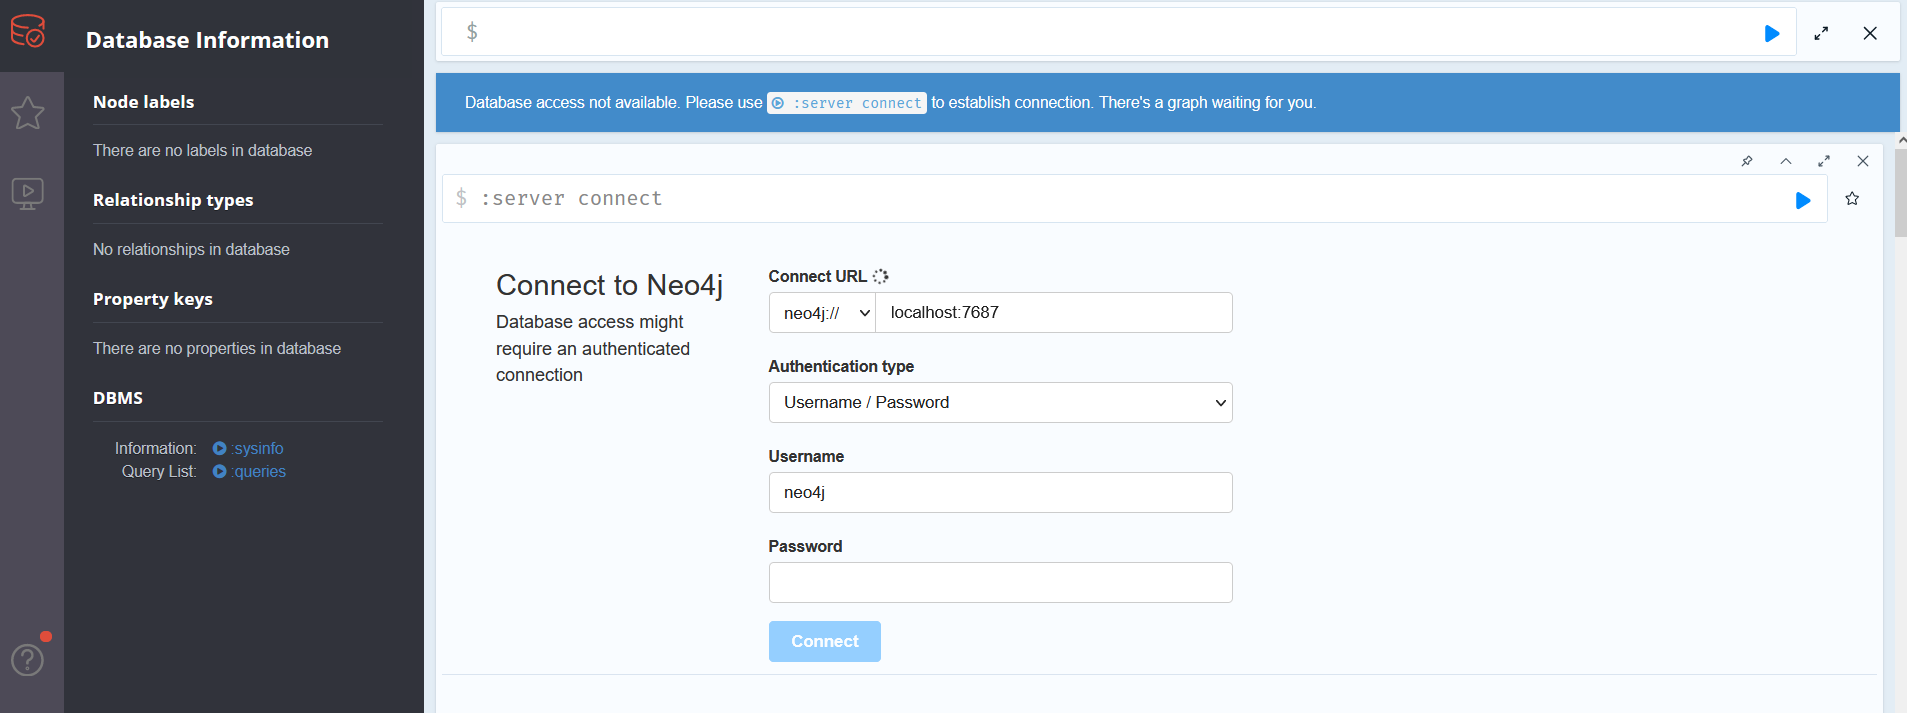

Die Daten können dann mit hilfe von csv, was vorher importiert wurde, einglesen werden und nachdem die Nodes deklariert wurden, kann der Graph erstellt werden mit py2neo.

Um abzufragen wie viele Nodes in Der Tabelle sind, kann diese Query verwendet werden:

In [ ]:
with driver.session() as session:
    result = session.run("MATCH (n) RETURN count(n) AS node_count")
    for record in result:
        print(record["node_count"])

In Neo4j wird as Sprache "Cypher" verwendet. In dieser Sprache sind die Nodes mit () dargestellt und die Edges mit [] dargestellt. Hier werden alle Patienten die Covid gehabt haben ausgegeben:

In [ ]:
cypher_query = """
MATCH (t:Tests)
RETURN *

"""

result = graph.run(cypher_query)

# Print the result
for record in result:
    print(record)

Dies kann auch mit panda dargestellt werden:

In [ ]:
import pandas as pd

# Assuming you have already executed the cypher_query and stored the result in 'result'
cypher_query = """
MATCH (p:Patient) WHERE p.covid='1'
RETURN p.kalenderWoche, p.wohnort, p.Geschlecht, p.covid, p.influenza, p.rsv, p.sonstige, p.aufnahmen, p.bev_zahl

"""

result = graph.run(cypher_query)

# Extract data from result
data = [dict(record) for record in result]

# Convert the result to a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


In dem Neo4j Browser kann man auch alle vorhandenen Eigenschaften einer Column sehen. Dies wird erreicht durch das Anklicken des markierten Feldes:

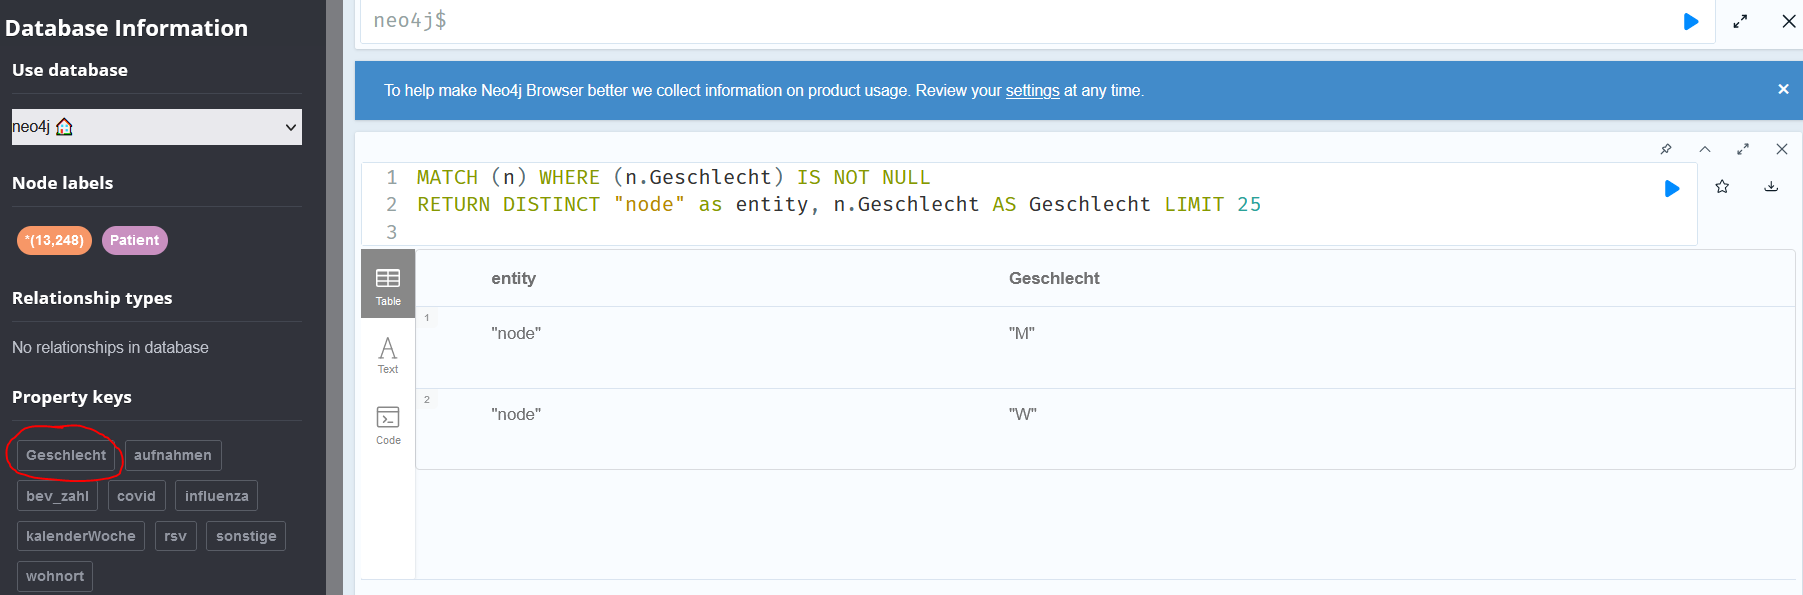

Danach kann der Container wieder geschlossen werden.

In [ ]:
!docker ps

In [ ]:
!docker-compose down

In [ ]:
!docker-compose -p completx_sql down

In [ ]:
!docker volume ls

Um ein Volume zu löschen, kann man wieder folgenden Befehl verwenden:

In [ ]:
!docker volume rm completx_sql_neo4j-data

Anbei ist ein GitHub-Repository zu finden, in dem einige Queries sowie Videos verlinkt sind, die Ihnen helfen können, Cypher und Neo4j besser zu verstehen:
https://github.com/cj2001/bite_sized_data_science/tree/main

Ebenfalls sind in der Dokumentation von Neo4j viele hilfreiche Hinweise zu finden, zum Beispiel zum Import von CSV-Dateien über Python:
https://neo4j.com/docs/getting-started/data-import/csv-import/

Zuletzt noch ein Cheatsheet für Cypher: https://neo4j.com/docs/cypher-cheat-sheet/5/auradb-enterprise/